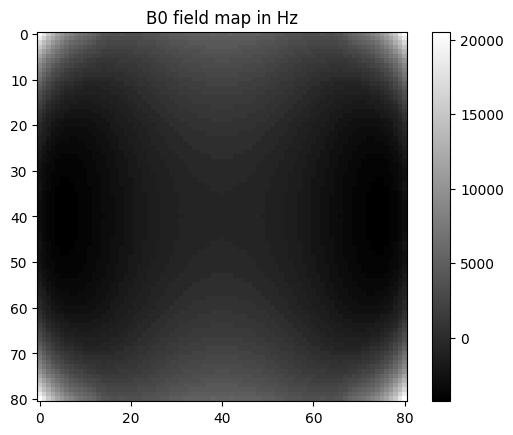

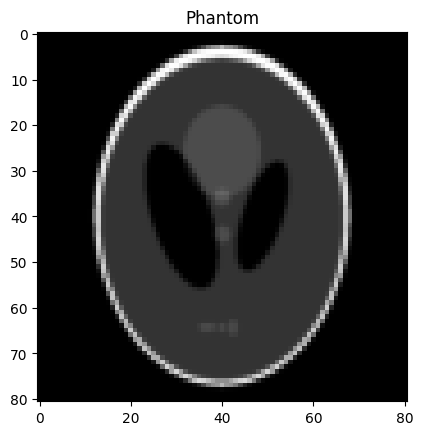

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import pandas as pd

# Re-generate and resize Shepp-Logan phantom
phantom = shepp_logan_phantom()
phantom = resize(phantom, (81, 81))
#phantom /= np.max(phantom)
phantom = phantom * (1 + 1j)  # Make the phantom complex


N_spins = 81  # Number of spins in the phantom
# # Phantom is a 2D delta function (single point in the center)
# phantom = np.zeros((N_spins, N_spins), dtype=np.complex128)  
# phantom[N_spins//2, N_spins//2] = 1

# Load the B0 field map from the csv file
B0_field_map = pd.read_csv('2Dslice.csv', header=None).values
gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
B0_field_map  = (B0_field_map * gamma)/(2*np.pi * 10000)  # Convert to Hz/T
B0_mean = np.mean(B0_field_map)  # Mean value of the B0 field map
B0_field_map -= np.mean(B0_field_map) # Dividing by the mean value of the B0 field map
B0_field_map *= 6


# Plot the B0 field map
plt.title('B0 field map in Hz')
plt.imshow(B0_field_map, cmap='gray')
plt.colorbar()  # Add a color bar to the plot
plt.show()



# Plot the phantom
plt.title('Phantom')
plt.imshow(np.abs(phantom), cmap='gray')
plt.show()



g_mult = 6 # Gradient multiplication factor
Gx = 0.004755753 * g_mult  # Gradient strength in T/m
Gy = 0.004755753 * g_mult # Gradient strength in T/m
B0 = 1.0  # B0 field in T

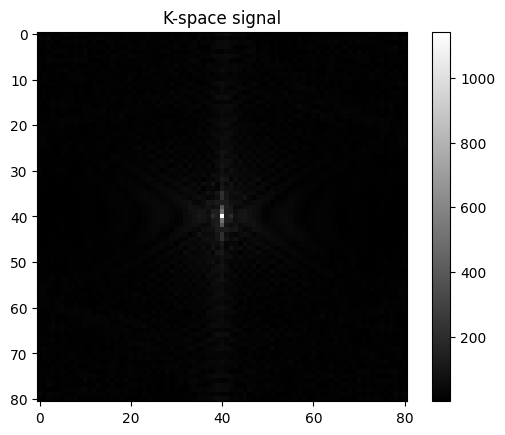

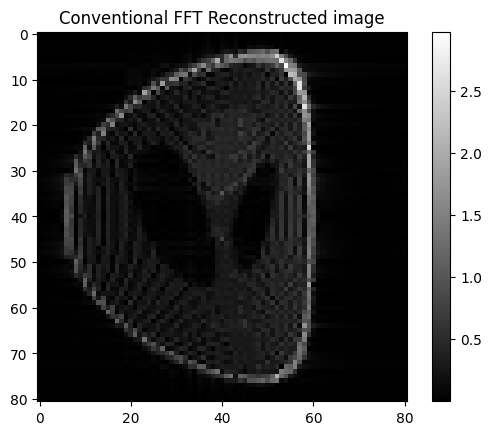

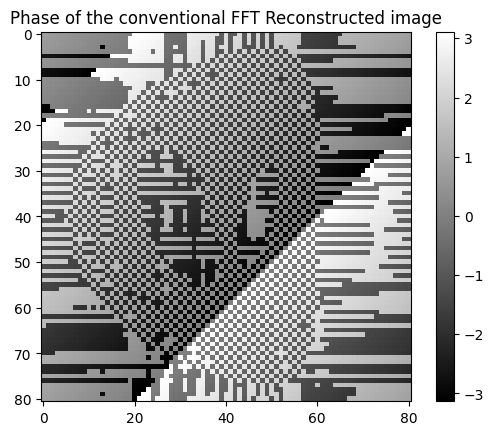

In [13]:
# Time intervals for the gradients
tau = 2e-3
time = np.linspace(-tau/2,tau/2,N_spins)

# B0 field inhomogeneities in the x and y directions

# Gradient fields (assuming same for x and y directions)
Gx_values = time * Gx
Gy_values = time * Gx

# k-space trajectory (assuming same for x and y directions)
kx_values = gamma * Gx_values 
ky_values = gamma * Gy_values

# Define field of view
FOV = .2  # meters
x_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
x_values, y_values = np.meshgrid(x_values, y_values)  # Create 2D coordinate grid


# Compute k-space values
k_space = np.zeros((N_spins, N_spins), dtype=np.complex128)
for i, kx in enumerate(kx_values):
    for j, ky in enumerate(ky_values):
        k_space[i, j] = np.sum(phantom * np.exp(-1j * (kx * x_values + ky * y_values)) * np.exp(-1j * 2 * np.pi * B0_field_map * time[i]))



# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space), cmap='gray')
plt.title('K-space signal')
plt.colorbar()
plt.show()

dwll_time = tau/N_spins

readout_bandwidth =  1/dwll_time


# Apply inverse FFT
reconstructed_image = ifft2(k_space)
reconstructed_image_1 = fftshift(reconstructed_image)



# Plot the reconstructed image
plt.figure()
plt.imshow(np.abs(reconstructed_image_1.T), cmap='gray')
plt.title('Conventional FFT Reconstructed image')
plt.colorbar()
plt.show()

# Plot the reconstructed image
plt.figure()
plt.imshow(np.angle(reconstructed_image_1.T), cmap='gray')
plt.title('Phase of the conventional FFT Reconstructed image')
plt.colorbar()
plt.show()



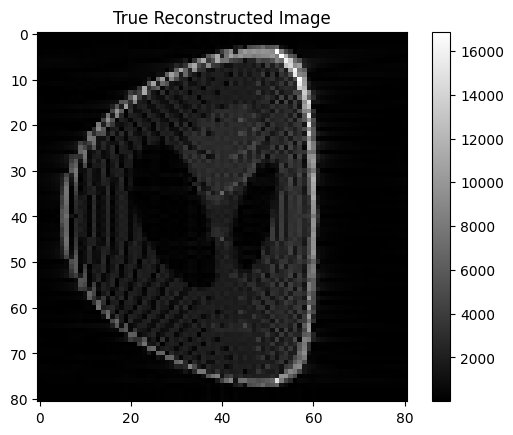

In [14]:
x_values_1 = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values_1 = np.linspace(-FOV / 2, FOV / 2, N_spins)


def inverse_fourier_2d(k_space):
    # Allocate a space for the output image
    image = np.zeros((N_spins, N_spins), dtype=np.complex128)
    
    # Iterate through each pixel in k-space
    for m in range(N_spins):
        for n in range(N_spins):
            # For each pixel, calculate the inverse Fourier transform
            for i in range(N_spins):
                for j in range(N_spins):
                    image[m, n] += k_space[i, j] * np.exp(1j * (kx_values[i] * x_values_1[m] + ky_values[j] * y_values_1[n])) * np.exp(1j * gamma * B0_field_map[m,n] * 2 * tau)
    

    
    return image

# Apply the inverse Fourier transform to the k-space data
reconstructed_image = inverse_fourier_2d(k_space)

# Plot the absolute value of the reconstructed image
plt.figure()
plt.imshow(np.abs(reconstructed_image.T), cmap='gray')
plt.colorbar()
plt.title('True Reconstructed Image')
plt.show()
